#Sample Code to use AlphaVantage API to implement simple SMA crossover strategy

In [14]:
# Step 1: Import your libraries here
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [15]:
# Step 2: Store my API key in a variable
api_key = 'HV2OK5AMP0J3SX3V'

Step 3: Read the Alphavantage documentation - https://www.alphavantage.co/documentation/

In [16]:
# Step 4: test my GET request - here I am using Singapore Post Limited (SPSTF) as my ticker/ symbol
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPSTF&outputsize=full&apikey=api_key'
response = requests.get(url)


In [17]:
# Step 5: Declare a new variable and assign  Time Series (Daily) to it, then turn dictionary into a DataFrame
data = response.json()
x = data['Time Series (Daily)']
SPSTF = pd.DataFrame.from_dict(x, orient='index')
SPSTF

,1. open,2. high,3. low,4. close,5. volume
2021-04-07,0.5604,0.5604,0.5604,0.5604,0
2021-04-06,0.5604,0.5604,0.5604,0.5604,20000
2021-04-05,0.5058,0.5058,0.5058,0.5058,0
2021-04-01,0.5058,0.5058,0.5058,0.5058,0
2021-03-31,0.5058,0.5058,0.5058,0.5058,0
...,...,...,...,...,...
2007-07-19,0.7900,0.7900,0.7900,0.7900,11000
2007-07-18,0.8000,0.8000,0.8000,0.8000,0
2007-07-17,0.8000,0.8000,0.8000,0.8000,0
2007-07-16,0.8000,0.8000,0.8000,0.8000,0


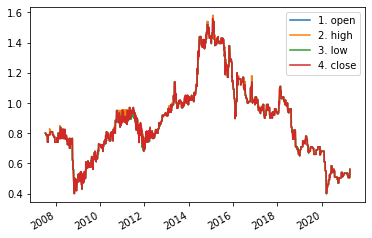

In [ ]:
## Convert string columns into numeric data, index column  into DateTime, then plot the graph
for i in range(5):
  SPSTF.iloc[:,i] = pd.to_numeric(SPSTF.iloc[:,i])

idx = SPSTF.index
idx = pd.to_datetime(idx)
SPSTF.index = idx

SPSTF.iloc[:,0:4].plot()


In [ ]:
SPSTF.dtypes

1. open      float64
2. high      float64
3. low       float64
4. close     float64
5. volume      int64
dtype: object

In [ ]:
# Sort your DataFrame's index
SPSTF = SPSTF.sort_index()

# Create a new column that contains the interday percentage change
SPSTF['interday_percentage_change'] = SPSTF['4. close'].pct_change()

## Implement a  buy-and-hold strategy - Create a column which contains 100 * 4.close 
SPSTF['portfolio_hold'] = 100 * SPSTF['4. close']


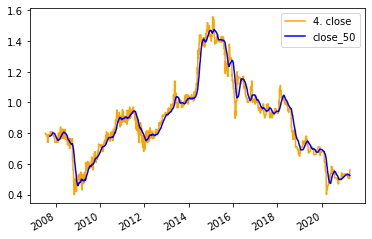

In [ ]:
## Implement a Simple Moving Average (SMA) strategy - Create a column containing a 50-day window SMA
SPSTF['close_50'] = SPSTF['4. close'].rolling(window=50).mean()
SPSTF[['4. close', 'close_50']].plot(color=["orange", "blue"])


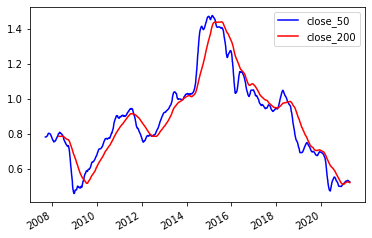

In [ ]:
## Create another column containing a 200-day window SMA
SPSTF['close_200'] = SPSTF['4. close'].rolling(window=200).mean()
SPSTF[['close_50', 'close_200']].plot(color=["blue", "red"])



In [ ]:
# Drop all rows containing NA
SPSTF_dropna = SPSTF.dropna()
SPSTF_dropna

,1. open,2. high,3. low,4. close,5. volume,interday_percentage_change,portfolio_hold,close_50,close_200
2008-04-28,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.800840,0.784131
2008-04-29,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.801340,0.784256
2008-04-30,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.801840,0.784381
2008-05-01,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.802340,0.784506
2008-05-02,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.802840,0.784631
...,...,...,...,...,...,...,...,...,...
2021-03-31,0.5058,0.5058,0.5058,0.5058,0,0.000000,50.58,0.524432,0.520512
2021-04-01,0.5058,0.5058,0.5058,0.5058,0,0.000000,50.58,0.523848,0.520141
2021-04-05,0.5058,0.5058,0.5058,0.5058,0,0.000000,50.58,0.523264,0.519770
2021-04-06,0.5604,0.5604,0.5604,0.5604,20000,0.107948,56.04,0.523772,0.519672


#Implement a simple SMA crossover strategy


1. You need to keep track of how many share units you have
2. You need to keep track of how much cash you have
3. If close_50 > close_200, you buy all the shares using cash unless you already have shares then you do nothing
4. If close_200 > close_50, you sell all the shares you have and store cash only unless you have only cash then you do nothing
5. At any point in time, you either have only shares or cash, but never both at the same time

In [ ]:
# initialize a variable called "shares", and assign 100 to it - the number of shares at the start
shares = 100

# initialize a variable called "cash", and assign 0 to it - how much liquid money at the start
cash = 0

# initialize an empty list called "portfolio_sma"
portfolio_sma = []

# initialize an empty list called "cash_list"
cash_list = []

for index, row in SPSTF_dropna.iterrows():
    # in a particular row, check if "close_50" is more than "close_200"
    if row['close_50'] > row['close_200']:

        # if "close_50" is more than "close_200", check if "shares" > 0
        if shares > 0:

          portfolio_sma.append(shares * row['4. close'])      # append "shares" * the row's "4. close" price into "portfolio_sma"
          cash_list.append(cash)                              # append "cash" into "cash_list"

        else:

          shares = cash/ row['4. close']                      # declare "shares" to be equals to "cash" divided by the row's "4. close"
          cash = 0                                            # declare "cash" to be 0 (because you spent it all buying "shares")

          portfolio_sma.append(shares * row['4. close'])      # append "shares" * the row's "4. close" price into "portfolio_sma"
          cash_list.append(cash)                              # append "cash" into "cash_list"

    else:   # in this case you have "close_200" more than "close_50"

        # check if you have "shares", i.e. more than 0. Because you have to sell your shares
        if shares > 0:

          cash = shares * row['4. close']                     # update the value of "cash" to be "shares" multiplied by the row's "4. close"
          shares = 0                                          # update "shares" to be 0 (because you sold all your shares)

          portfolio_sma.append(shares * row['4. close'])      # append "shares" * the row's "4. close" price into "portfolio_sma"
          cash_list.append(cash)                              # append "cash" into "cash_list"

        else:

          portfolio_sma.append(shares * row['4. close'])      # append "shares" * the row's "4. close" price into "portfolio_sma"
          cash_list.append(cash)                              # append "cash" into "cash_list"


# declare a new column named "portfolio_sma" in your DataFrame which contains "portfolio_sma"
SPSTF_dropna['portfolio_sma'] = portfolio_sma
# declare a new column named "cash_sma" in your DataFrame which contains "cash_list"
SPSTF_dropna['cash_sma'] = cash_list

# check your DataFrame
SPSTF_dropna

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,1. open,2. high,3. low,4. close,5. volume,interday_percentage_change,portfolio_hold,close_50,close_200,portfolio_sma,cash_sma
2008-04-28,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.800840,0.784131,82.500000,0.0
2008-04-29,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.801340,0.784256,82.500000,0.0
2008-04-30,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.801840,0.784381,82.500000,0.0
2008-05-01,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.802340,0.784506,82.500000,0.0
2008-05-02,0.8250,0.8250,0.8250,0.8250,0,0.000000,82.50,0.802840,0.784631,82.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,0.5058,0.5058,0.5058,0.5058,0,0.000000,50.58,0.524432,0.520512,164.231823,0.0
2021-04-01,0.5058,0.5058,0.5058,0.5058,0,0.000000,50.58,0.523848,0.520141,164.231823,0.0
2021-04-05,0.5058,0.5058,0.5058,0.5058,0,0.000000,50.58,0.523264,0.519770,164.231823,0.0
2021-04-06,0.5604,0.5604,0.5604,0.5604,20000,0.107948,56.04,0.523772,0.519672,181.960288,0.0
